In [2]:

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import shapely
import matplotlib.pyplot as plt
import pysal
import bokeh
import cartopy
import statsmodels
import sklearn
import geoplot
import osmnx
import folium
import dash
import tifffile
import rasterio
import rasterstats


C:\Users\evbruh\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
from pathlib import Path
data_base = Path('C:/.../Caribbean_Challenge/stac/')

In [4]:
import os
paths = []
for root, dirs, files in os.walk(data_base, topdown=False):
    for name in files:
        paths.append(os.path.join(root, name))
    for name in dirs:
        paths.append(os.path.join(root, name))


In [5]:
geo_tiffs = [p for p in paths if p.endswith('.tif')]
geo_jsons = [p for p in paths if 'train' in p and '.geojson' in p]
geo_metas = [p for p in paths if 'labels-train' in p]
regions = list(zip(geo_tiffs, geo_jsons, geo_metas))


In [6]:
import random
eg_region = random.choice(regions)
eg_tiff_path, eg_geojson_path, eg_meta_path = eg_region


In [21]:
eg_tiff = tifffile.imread(eg_tiff_path)

In [22]:
eg_tiff.shape, eg_tiff.dtype

((27604, 26641, 4), dtype('uint8'))

In [23]:
region_labels = gpd.read_file(eg_geojson_path)
region_labels

id    roof_material  verified  \
0     7a314698  concrete_cement      True   
1     7a30b066  concrete_cement      True   
2     7a1ce13a  concrete_cement      True   
3     7a2f9712  concrete_cement      True   
4     7a416e42  concrete_cement      True   
...        ...              ...       ...   
3346  7a26a65c  concrete_cement      True   
3347  7a220a34            other      True   
3348  7a26a274  concrete_cement      True   
3349  7a25426c  concrete_cement      True   
3350  7a1da264    healthy_metal      True   

                                               geometry  
0     POLYGON ((-90.58355 14.62727, -90.58353 14.627...  
1     POLYGON ((-90.58346 14.62740, -90.58340 14.627...  
2     POLYGON ((-90.58342 14.62725, -90.58341 14.627...  
3     POLYGON ((-90.58293 14.62739, -90.58279 14.627...  
4     POLYGON ((-90.58279 14.62729, -90.58277 14.627...  
...                                                 ...  
3346  POLYGON ((-90.58178 14.62049, -90.58168 14.620...  
3347  POLYGON ((-90.58188 14.62033, -90.58186 14.620...  
3348  POLYGON ((-90.58204 14.62060, -90.58197 14.620...  
3349  POLYGON ((-90.58188 14.62068, -90.58184 14.620...  
3350  POLYGON ((-90.58261 14.62229, -90.58259 14.622...  

[3351 rows x 4 columns]

In [67]:
eg_poly = region_labels.iloc[100].geometry

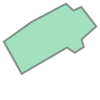

In [69]:
eg_poly

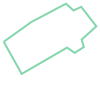

In [71]:
eg_poly.exterior

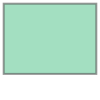

In [73]:
eg_poly.envelope

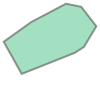

In [68]:
eg_poly.convex_hull

In [24]:
import json
with open(eg_meta_path) as json_file:
    metadata = json.load(json_file)
metadata


{'type': 'Feature',
 'stac_version': '0.8.0',
 'id': 'mixco_1_and_ebenezer-labels-train',
 'properties': {'datetime': '2019-08-30T12:00:00+00:00',
  'label:description': 'Building Footprints with Roof Material Classification. Note: Building Footprints are not exhaustively labeled.',
  'label:type': 'vector',
  'label:property': ['roof_material'],
  'label:classes': [{'name': 'roof_material',
    'classes': ['healthy_metal',
     'irregular_metal',
     'concrete_cement',
     'other',
     'incomplete']}],
  'label:task': ['classification'],
  'label:method': ['manual'],
  'label:overview': {'property_key': 'roof_material',
   'counts': [{'name': 'healthy_metal', 'count': 863},
    {'name': 'irregular_metal', 'count': 1540},
    {'name': 'concrete_cement', 'count': 806},
    {'name': 'other', 'count': 142},
    {'name': 'incomplete', 'count': 0}]}},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-90.59050528, 14.6171014],
    [-90.58003224, 14.6171014],
    [-90.58003224, 14.6276

In [25]:
min_lat, min_lon, max_lat, max_lon = metadata['bbox']
normalize = lambda lat_, lon_: ((lat_ - min_lat)/(max_lat - min_lat), (lon_ - min_lon)/(max_lon - min_lon)) 

In [26]:
from shapely import geometry

# TODO: Add normalizing coordinates as a column in the dataframe.
def normalized_bbox(poly):
    if poly.type is 'Polygon':
        norm_poly = normalize_polygon(poly)
    elif poly.type is 'MultiPolygon':
        norm_poly = geometry.MultiPolygon([normalize_polygon(poly_) for poly_ in list(poly)])
    else:
        print('Only Polygons and MultiPolygons supported! Geometry type: {}'.format(poly.type))
        raise ValueError
    return norm_poly

def normalize_polygon(polygon):
    return geometry.Polygon([normalize(p[0], p[1]) for p in list(polygon.exterior.coords)])

def set_normalized_bbox(row, target_col = None):
    bbox = row.geometry
    norm_bbox = normalized_bbox(bbox)
    row[target_col] = norm_bbox
    return row

def normalize_all_bbox(df, target_col = 'norm_geometry'):
    df[target_col] = np.empty_like(df.geometry)
    df = df.apply(set_normalized_bbox, args=(target_col,), axis=1)
    df = df.set_geometry(target_col)
    return df
    
region_labels = normalize_all_bbox(region_labels)
region_labels

id    roof_material  verified  \
0     7a314698  concrete_cement      True   
1     7a30b066  concrete_cement      True   
2     7a1ce13a  concrete_cement      True   
3     7a2f9712  concrete_cement      True   
4     7a416e42  concrete_cement      True   
...        ...              ...       ...   
3346  7a26a65c  concrete_cement      True   
3347  7a220a34            other      True   
3348  7a26a274  concrete_cement      True   
3349  7a25426c  concrete_cement      True   
3350  7a1da264    healthy_metal      True   

                                               geometry  \
0     POLYGON ((-90.58355 14.62727, -90.58353 14.627...   
1     POLYGON ((-90.58346 14.62740, -90.58340 14.627...   
2     POLYGON ((-90.58342 14.62725, -90.58341 14.627...   
3     POLYGON ((-90.58293 14.62739, -90.58279 14.627...   
4     POLYGON ((-90.58279 14.62729, -90.58277 14.627...   
...                                                 ...   
3346  POLYGON ((-90.58178 14.62049, -90.58168 14.620...   
3347  POLYGON ((-90.58188 14.62033, -90.58186 14.620...   
3348  POLYGON ((-90.58204 14.62060, -90.58197 14.620...   
3349  POLYGON ((-90.58188 14.62068, -90.58184 14.620...   
3350  POLYGON ((-90.58261 14.62229, -90.58259 14.622...   

                                          norm_geometry  
0     POLYGON ((0.66432 0.96118, 0.66611 0.97238, 0....  
1     POLYGON ((0.67286 0.97324, 0.67836 0.97234, 0....  
2     POLYGON ((0.67655 0.95937, 0.67794 0.96936, 0....  
3     POLYGON ((0.72373 0.97213, 0.73648 0.97031, 0....  
4     POLYGON ((0.73666 0.96289, 0.73819 0.97434, 0....  
...                                                 ...  
3346  POLYGON ((0.83320 0.32015, 0.84253 0.31828, 0....  
3347  POLYGON ((0.82346 0.30533, 0.82566 0.30485, 0....  
3348  POLYGON ((0.80794 0.33026, 0.81491 0.32941, 0....  
3349  POLYGON ((0.82322 0.33836, 0.82786 0.33752, 0....  
3350  POLYGON ((0.75396 0.49035, 0.75550 0.49421, 0....  

[3351 rows x 5 columns]

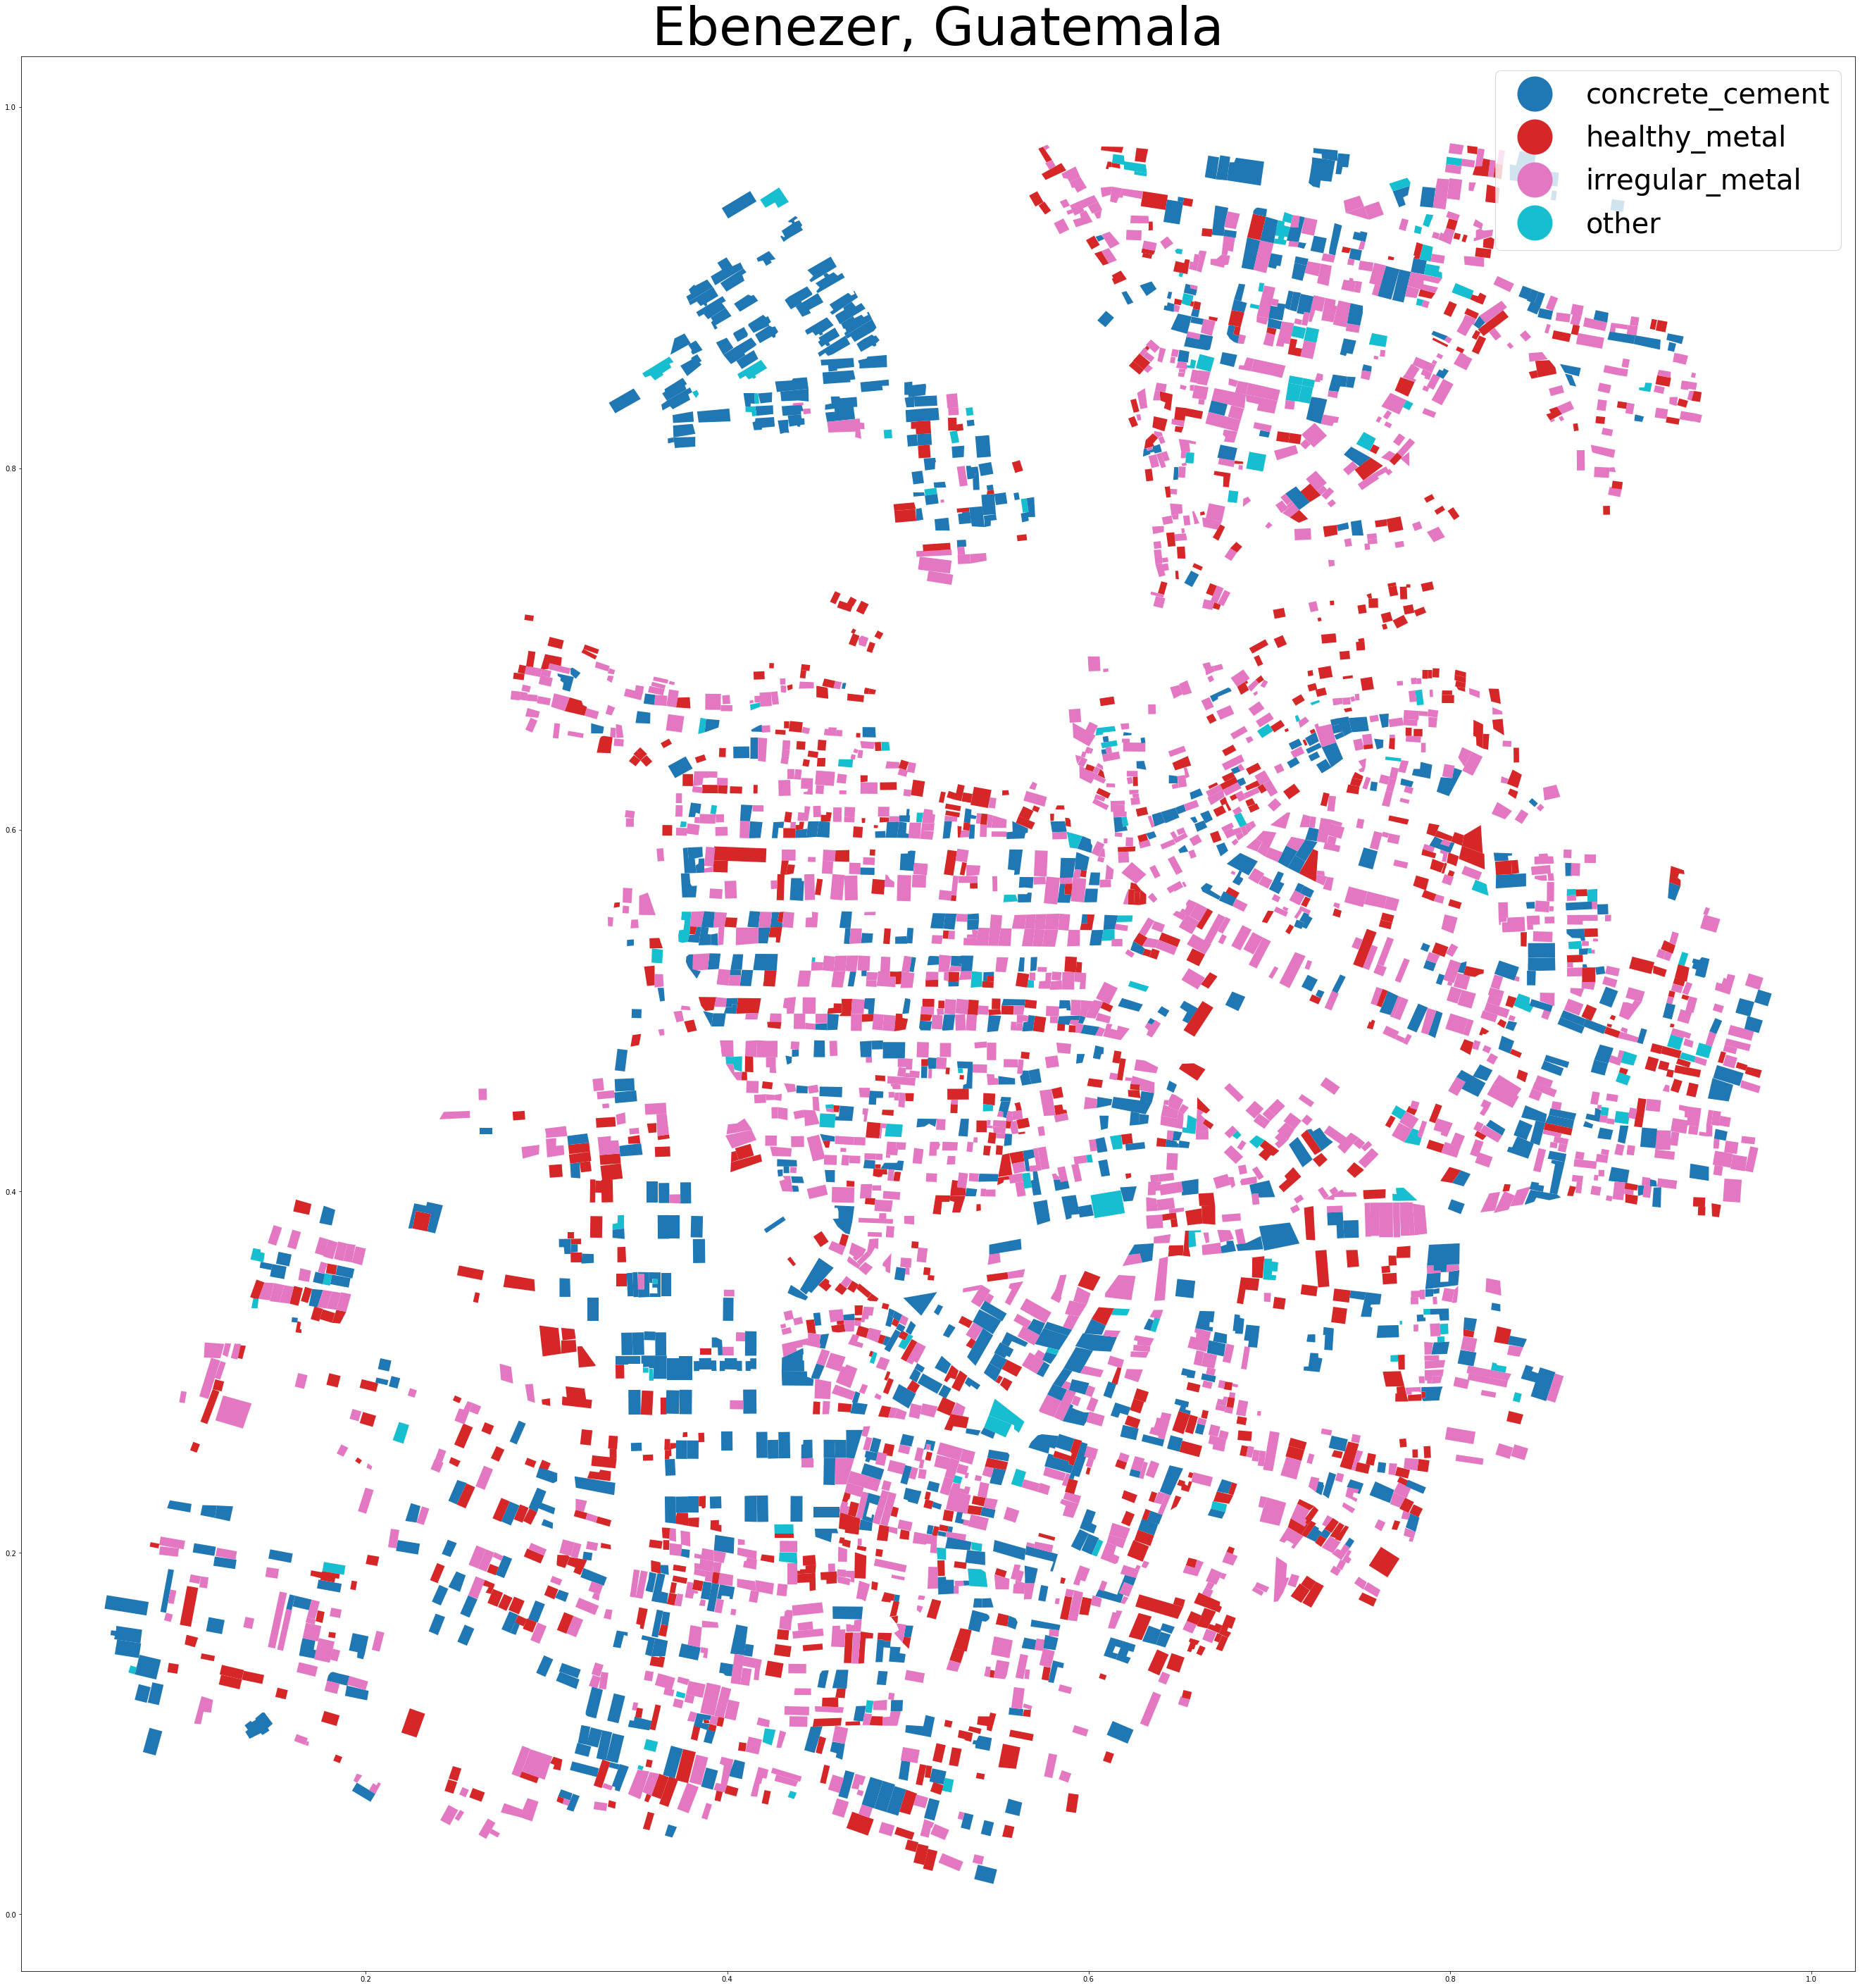

In [27]:
fig, ax = plt.subplots(1, figsize=(50,50))
region_labels.plot(ax = ax,
                   column = 'roof_material', 
                   legend=True,
                   legend_kwds={'fontsize':  40, 'markerscale':5})
ax.set_title('Ebenezer, Guatemala', fontsize=75)
fig.savefig('C:/.../ebenezer_guatemala_labels_w_legend.png')
plt.show()


In [60]:
def get_centroid(row, target_col):
    cx, cy = list(row[target_col].centroid.coords)[0]
    row['cx'] = cx
    row['cy'] = cy
    row['centroid'] = row[target_col].centroid
    return row
    

def get_all_centroids(df, target_col = 'norm_geometry'):
    df = df.set_geometry(target_col)
    df['cx'] = np.zeros_like(df.geometry)
    df['cy'] = np.zeros_like(df.geometry)
    df['centroid'] = np.zeros_like(df.geometry)
    df = df.apply(get_centroid, args=(target_col,), axis=1)
    return df

region_labels = get_all_centroids(region_labels)
region_labels

id    roof_material  verified  \
0     7a314698  concrete_cement      True   
1     7a30b066  concrete_cement      True   
2     7a1ce13a  concrete_cement      True   
3     7a2f9712  concrete_cement      True   
4     7a416e42  concrete_cement      True   
...        ...              ...       ...   
3346  7a26a65c  concrete_cement      True   
3347  7a220a34            other      True   
3348  7a26a274  concrete_cement      True   
3349  7a25426c  concrete_cement      True   
3350  7a1da264    healthy_metal      True   

                                               geometry  \
0     POLYGON ((-90.58355 14.62727, -90.58353 14.627...   
1     POLYGON ((-90.58346 14.62740, -90.58340 14.627...   
2     POLYGON ((-90.58342 14.62725, -90.58341 14.627...   
3     POLYGON ((-90.58293 14.62739, -90.58279 14.627...   
4     POLYGON ((-90.58279 14.62729, -90.58277 14.627...   
...                                                 ...   
3346  POLYGON ((-90.58178 14.62049, -90.58168 14.620...   
3347  POLYGON ((-90.58188 14.62033, -90.58186 14.620...   
3348  POLYGON ((-90.58204 14.62060, -90.58197 14.620...   
3349  POLYGON ((-90.58188 14.62068, -90.58184 14.620...   
3350  POLYGON ((-90.58261 14.62229, -90.58259 14.622...   

                                          norm_geometry        cx        cy  \
0     POLYGON ((0.6643228224423419 0.961183411983115...  0.668306  0.966537   
1     POLYGON ((0.6728552916186198 0.973240633603193...  0.674518  0.966121   
2     POLYGON ((0.6765515730236161 0.95937099458789,...  0.687091  0.964257   
3     POLYGON ((0.7237279688581894 0.972127563126566...  0.728702  0.964316   
4     POLYGON ((0.736661981179627 0.9628859995835128...  0.740371  0.969196   
...                                                 ...       ...       ...   
3346  POLYGON ((0.8331965419352135 0.320149981576608...  0.837031  0.316914   
3347  POLYGON ((0.8234625732121892 0.305329217601270...  0.826814  0.302247   
3348  POLYGON ((0.8079403301521428 0.330255694682024...  0.810991  0.326570   
3349  POLYGON ((0.8232181284317691 0.338362849866594...  0.825419  0.335940   
3350  POLYGON ((0.7539581072735698 0.490351900408626...  0.756399  0.492141   

      intra_class_nobs  intra_class_dist_min  intra_class_dist_max  \
0                  805              0.006226              1.049965   
1                  805              0.006226              1.053103   
2                  805              0.012711              1.058698   
3                  805              0.010240              1.083067   
4                  805              0.009587              1.093968   
...                ...                   ...                   ...   
3346               805              0.019521              0.787275   
3347               141              0.019261              0.774081   
3348               805              0.016868              0.764744   
3349               805              0.017203              0.781342   
3350               862              0.015911              0.752629   

      intra_class_dist_mean  intra_class_dist_var  intra_class_dist_skew  \
0                  0.545300              0.059229              -0.196835   
1                  0.546074              0.059490              -0.197209   
2                  0.547031              0.059913              -0.196095   
3                  0.557909              0.061155              -0.191613   
4                  0.565677              0.061581              -0.191687   
...                     ...                   ...                    ...   
3346               0.417918              0.030640              -0.054523   
3347               0.419589              0.034223              -0.193403   
3348               0.397727              0.029873              -0.008403   
3349               0.403903              0.030034              -0.049936   
3350               0.325670              0.022125               0.351419   

      intra_class_dist_kurtosis                            

In [29]:
region_labels['intra_class_nobs'] = np.zeros_like(region_labels.geometry)
region_labels['intra_class_dist_min'] = np.zeros_like(region_labels.geometry)
region_labels['intra_class_dist_max'] = np.zeros_like(region_labels.geometry)
region_labels['intra_class_dist_mean'] = np.zeros_like(region_labels.geometry)
region_labels['intra_class_dist_var'] = np.zeros_like(region_labels.geometry)
region_labels['intra_class_dist_skew'] = np.zeros_like(region_labels.geometry)
region_labels['intra_class_dist_kurtosis'] = np.zeros_like(region_labels.geometry)


In [30]:
from scipy.spatial.distance import cdist
from scipy import stats

def get_row_summary_stats(row):
    row = row[row>0]
    summary_stats = stats.describe(row)
    return summary_stats

def set_row_summary_stats(row, sub_df, dist_mat):
    df_idx = row.name
    sub_df_idx = sub_df.index.get_loc(df_idx)
    mat_row = dist_mat[sub_df_idx]
    summary_stats = get_row_summary_stats(mat_row)
    row['intra_class_nobs'] = summary_stats.nobs
    row['intra_class_dist_min'] = summary_stats.minmax[0]
    row['intra_class_dist_max'] = summary_stats.minmax[1]
    row['intra_class_dist_mean'] = summary_stats.mean
    row['intra_class_dist_var'] = summary_stats.variance
    row['intra_class_dist_skew'] = summary_stats.skewness
    row['intra_class_dist_kurtosis'] = summary_stats.kurtosis
    return row

for roof_material_ in region_labels.roof_material.unique():
    sub_df = region_labels[region_labels.roof_material == roof_material_]
    cs = sub_df[['cy', 'cx']].values
    dists = cdist(cs, cs)
    sub_df = sub_df.apply(set_row_summary_stats, args=(sub_df, dists,), axis=1)
    region_labels.iloc[sub_df.index] = sub_df
    
    

In [31]:
region_labels

id    roof_material  verified  \
0     7a314698  concrete_cement      True   
1     7a30b066  concrete_cement      True   
2     7a1ce13a  concrete_cement      True   
3     7a2f9712  concrete_cement      True   
4     7a416e42  concrete_cement      True   
...        ...              ...       ...   
3346  7a26a65c  concrete_cement      True   
3347  7a220a34            other      True   
3348  7a26a274  concrete_cement      True   
3349  7a25426c  concrete_cement      True   
3350  7a1da264    healthy_metal      True   

                                               geometry  \
0     POLYGON ((-90.58355 14.62727, -90.58353 14.627...   
1     POLYGON ((-90.58346 14.62740, -90.58340 14.627...   
2     POLYGON ((-90.58342 14.62725, -90.58341 14.627...   
3     POLYGON ((-90.58293 14.62739, -90.58279 14.627...   
4     POLYGON ((-90.58279 14.62729, -90.58277 14.627...   
...                                                 ...   
3346  POLYGON ((-90.58178 14.62049, -90.58168 14.620...   
3347  POLYGON ((-90.58188 14.62033, -90.58186 14.620...   
3348  POLYGON ((-90.58204 14.62060, -90.58197 14.620...   
3349  POLYGON ((-90.58188 14.62068, -90.58184 14.620...   
3350  POLYGON ((-90.58261 14.62229, -90.58259 14.622...   

                                          norm_geometry        cx        cy  \
0     POLYGON ((0.6643228224423419 0.961183411983115...  0.668306  0.966537   
1     POLYGON ((0.6728552916186198 0.973240633603193...  0.674518  0.966121   
2     POLYGON ((0.6765515730236161 0.95937099458789,...  0.687091  0.964257   
3     POLYGON ((0.7237279688581894 0.972127563126566...  0.728702  0.964316   
4     POLYGON ((0.736661981179627 0.9628859995835128...  0.740371  0.969196   
...                                                 ...       ...       ...   
3346  POLYGON ((0.8331965419352135 0.320149981576608...  0.837031  0.316914   
3347  POLYGON ((0.8234625732121892 0.305329217601270...  0.826814  0.302247   
3348  POLYGON ((0.8079403301521428 0.330255694682024...  0.810991  0.326570   
3349  POLYGON ((0.8232181284317691 0.338362849866594...  0.825419  0.335940   
3350  POLYGON ((0.7539581072735698 0.490351900408626...  0.756399  0.492141   

      intra_class_nobs intra_class_dist_min intra_class_dist_max  \
0                  805           0.00622576              1.04997   
1                  805           0.00622576               1.0531   
2                  805            0.0127108               1.0587   
3                  805              0.01024              1.08307   
4                  805           0.00958722              1.09397   
...                ...                  ...                  ...   
3346               805             0.019521             0.787275   
3347               141            0.0192609             0.774081   
3348               805            0.0168677             0.764744   
3349               805            0.0172034             0.781342   
3350               862            0.0159111             0.752629   

     intra_class_dist_mean intra_class_dist_var intra_class_dist_skew  \
0                   0.5453            0.0592289             -0.196835   
1                 0.546074            0.0594904             -0.197209   
2                 0.547031             0.059913             -0.196095   
3                 0.557909             0.061155             -0.191613   
4                 0.565677            0.0615811             -0.191687   
...                    ...                  ...                   ...   
3346              0.417918            0.0306404            -0.0545226   
3347              0.419589            0.0342233             -0.193403   
3348              0.397727            0.0298731           -0.00840331   
3349              0.403903            0.0300339            -0.0499365   
3350               0.32567            0.0221248              0.351419   

     intra_class_dist_kurtosis  
0                    -0.809028  
1                    -0.795676  
2                   

In [33]:
import plotly.graph_objects as go

fig = go.Figure()
for roof_material_ in region_labels.roof_material.unique():
    sub_df = region_labels[region_labels.roof_material == roof_material_]
    fig.add_trace(go.Histogram(x = sub_df.intra_class_dist_mean,
                               nbinsx = 100, 
                               name = roof_material_ + ' intra_class_dist_mean',
                               histnorm='probability'))

# The two histograms are drawn on top of another
fig.update_layout(barmode='stack')
fig.show()

In [35]:
import plotly.graph_objects as go

fig = go.Figure()
for roof_material_ in region_labels.roof_material.unique():
    sub_df = region_labels[region_labels.roof_material == roof_material_]
    fig.add_trace(go.Histogram(x = sub_df.intra_class_dist_var,
                               nbinsx = 100, 
                               name = roof_material_ + ' intra_class_dist_var',
                               histnorm='probability'))

# The two histograms are drawn on top of another
fig.update_layout(barmode='stack')
fig.show()

In [36]:
import plotly.graph_objects as go

fig = go.Figure()
for roof_material_ in region_labels.roof_material.unique():
    sub_df = region_labels[region_labels.roof_material == roof_material_]
    fig.add_trace(go.Histogram(x = sub_df.intra_class_dist_skew,
                               nbinsx = 100, 
                               name = roof_material_ + ' intra_class_dist_skew',
                               histnorm='probability'))

# The two histograms are drawn on top of another
fig.update_layout(barmode='stack')
fig.show()

In [52]:
import plotly.figure_factory as ff

col = 'intra_class_dist_mean'

hist_data = [(region_labels[region_labels.roof_material == rm][col].values.astype('float32'), col + ' ' + rm) for rm in region_labels.roof_material.unique()]

histx, histy = zip(*hist_data)

fig = ff.create_distplot(list(histx), list(histy), bin_size=.005)
fig.show()


In [53]:
import plotly.figure_factory as ff

col = 'intra_class_dist_var'

hist_data = [(region_labels[region_labels.roof_material == rm][col].values.astype('float32'), col + ' ' + rm) for rm in region_labels.roof_material.unique()]

histx, histy = zip(*hist_data)

fig = ff.create_distplot(list(histx), list(histy), bin_size=.005)
fig.show()


In [54]:
import plotly.figure_factory as ff

col = 'intra_class_dist_skew'

hist_data = [(region_labels[region_labels.roof_material == rm][col].values.astype('float32'), col + ' ' + rm) for rm in region_labels.roof_material.unique()]

histx, histy = zip(*hist_data)

fig = ff.create_distplot(list(histx), list(histy), bin_size=.005)
fig.show()


In [55]:
import plotly.figure_factory as ff

col = 'intra_class_dist_kurtosis'

hist_data = [(region_labels[region_labels.roof_material == rm][col].values.astype('float32'), col + ' ' + rm) for rm in region_labels.roof_material.unique()]

histx, histy = zip(*hist_data)

fig = ff.create_distplot(list(histx), list(histy), bin_size=.005)
fig.show()
